# scram demonstration

- Using the [scram_docker container](https://hub.docker.com/r/sfletcher/scram_docker/)
- Notebook started in the project root directory via (Windows):
```
docker run -it --rm  -v ${PWD}:/work -p 8888:8888 sfletcher/scram_docker
```

#### Set up the Jupyter environment (optional)

In [30]:
%matplotlib inline
#To display pandas dataframes inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas

#### Example file and directory structure on the host

In [31]:
! tree

.
├── license
├── out_dir
├── ref
│   ├── GFP.fa
│   ├── TAIR10_transposable_elements.fa
│   └── ath_mir.fa
├── scram_demonstration.ipynb
└── seq
    ├── treatment_a_rep1.fa
    ├── treatment_a_rep2.fa
    ├── treatment_a_rep3.fa
    ├── treatment_b_rep1.fa
    ├── treatment_b_rep2.fa
    └── treatment_b_rep3.fa

3 directories, 11 files


#### scram help
- The scram aligner is in the container path
- In Jupyter notebook, use the ! symbol to run a non-Python CLI app

In [32]:
!scram -h

Fast and simple small RNA read alignment v0.2.0

Usage:
  scram [command]

Available Commands:
  compare     Compare normalised alignment counts and standard errors for 2 read file sets
  help        Help about any command
  profile     Align reads of length l from 1 read file set to all sequences in a reference file

Flags:
      --adapter string         3' adapter sequence to trim - FASTA & FASTQ only (default "nil")
  -r, --alignTo string         path/to/FASTA reference file
  -1, --fastxSet1 string       comma-separated path/to/read file set 1. GZIPped files must have .gz file extension
  -h, --help                   help for scram
  -l, --length string          comma-separated read (sRNA) lengths to align
      --maxLen int             Maximum read length to include for RPMR normalization (default 32)
      --minCount float         Minimum read count for alignment and to include for RPMR normalization (default 1)
      --minLen int             Minimum read length to include for RP

## Comparison alignments and scatter plots

- For comparing two treatments (e.g. wild-type verses mutant) - the output is the mean and standard error of the total alignments to each reference sequence
- By default, the alignment count of multi-mapping reads is split evenly between the number of loci aligned to (both within and among all reference sequences).  The -noSplit flag shows the maximum possible alignment count at each loci 
- Alignments are carried out seperately for each small RNA size (read length) entered in the -nt filed
- The read length aligned is appended to the alignment csv file name

#### Alignment of 2 x 3 replicates (treatment A & treatment B) x 3 read lengths (21, 22, 24 nt) to Arabidopsis transposable elements  FASTA reference file
- Read files are in collapsed FASTA format (generated by [FASTX-Toolkit](http://hannonlab.cshl.edu/fastx_toolkit/)), which is the default format for SCRAM 
- FASTQ or FASTA (non-collapsed) can also be used (with the readFileType flag).  GZIP compressed input is fine. 3' Adapters can be trimmed on-the-fly from FASTA and FASTQ reads (with the adapter flag).  Adapter trimming is quite stringent (12 5'adapter nucleotides must be all present, or the read is rejected), so a dedicated read QC/trimming software package may be desirable.  

In [33]:
!scram compare -r ref/TAIR10_transposable_elements.fa \
    -1 seq/treatment_a_rep1.fa,seq/treatment_a_rep2.fa,seq/treatment_a_rep3.fa \
    -2 seq/treatment_b_rep1.fa,seq/treatment_b_rep2.fa,seq/treatment_b_rep3.fa \
    -l 21,22,24 -o out_dir/treatment_a_vs_b 
    
    


Loading reads


SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_a_rep1.fa - 7,916,958 reads processed
seq/treatment_a_rep2.fa - 7,827,082 reads processed
seq/treatment_a_rep3.fa - 7,897,787 reads processed

SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_b_rep3.fa - 9,185,811 reads processed
seq/treatment_b_rep2.fa - 8,311,241 reads processed
seq/treatment_b_rep1.fa - 8,203,718 reads processed

Loading reference

No. of reference sequences:  31189
Combined length of reference sequences: 23,315,940 nt

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 24 nt reads

Alignment complete.  Total time taken = 15.746887639s


#### The normalised alignment count (reads per million reads) and standard error for the two treatments (columns) aligned to each reference sequence (rows) are generated
- data can be easily imported and manipulated in a Pandas dataframe
- NOTE: There's no need for data manipulation in Pandas prior to plotting - it's just a demo

In [34]:
comparison_alignment = pandas.read_csv('out_dir/treatment_a_vs_b_21.csv')

In [35]:
comparison_alignment.head()

Header  Mean count 1  \
0  AT3TE56475|+|13785373|13785436|ATDNA12T3_2|DNA...         0.466   
1  AT3TE55845|+|13718067|13718130|ATDNA12T3_2|DNA...         0.953   
2  AT5TE53195|+|14754521|14755395|ATREP15|RC/Heli...         0.001   
3  AT3TE45810|+|11021715|11022665|BOMZH1|DNA/MuDR...         0.034   
4  AT3TE47200|-|11319279|11319496|HELITRONY3|RC/H...         0.039   

   Std. err 1  Mean count 2  Std. err 2  
0    0.017302         0.427    0.022843  
1    0.019223         0.920    0.040779  
2    0.000003         0.000    0.000017  
3    0.004299         0.027    0.004598  
4    0.002143         0.037    0.002122

### scram_plot.py compare can be used to generate interactive scatter plots using the bokeh plotting library
- In Jupyter notebook, Python apps are executed using %run 

In [36]:
%run /scram_plot/scram_plot.py compare -h

usage: scram_plot.py compare [-h] [-plot_type PLOT_TYPE] [-a ALIGNMENT]
                             [-l LENGTH] [-xlab [X_LABEL [X_LABEL ...]]]
                             [-ylab [Y_LABEL [Y_LABEL ...]]] [-html] [-pub]
                             [-png] [-xylim XYLIM] [-fig_size FIG_SIZE]

optional arguments:
  -h, --help            show this help message and exit
  -plot_type PLOT_TYPE, --plot_type PLOT_TYPE
                        Bokeh plot type to display (log, log_error or all)
  -a ALIGNMENT, --alignment ALIGNMENT
                        sRNA alignment file prefix used by SCRAM profile (i.e.
                        exclude _21.csv, _22.csv, _24.csv)
  -l LENGTH, --length LENGTH
                        Comma-separated list of sRNA lengths to plot. SCRAM
                        alignment files must be available for each sRNA
                        length. For an miRNA alignment file, use 'mir' instead
                        of an integer
  -xlab [X_LABEL [X_LABEL ...]], --x_la

#### 2 plot types - log axis with standard error bars (deafult) or log axis
- plots are interactive - hover over each point of interest to identify header
- 21nt plots are green, 22nt pink, and 24nt blue
- standard error bars are shown (x -> Treatment A, y -> Treatment b) in the default log + se bars plot

#### Log plot with x,y standard error bars (default plot)

In [37]:
%run /scram_plot/scram_plot.py compare -a out_dir/treatment_a_vs_b \
    -l 24 \
    -xlab Treatment A (RPMR) \
    -ylab Treatment B (RPMR)

## miRNA comparison alignments / plots are a special case
- For the aligner, the ```--mir``` flag is required, and the ```-l``` flag and arguments are not - all lengths are aligned

In [38]:
!scram compare -r ref/ath_mir.fa \
    -1 seq/treatment_a_rep1.fa,seq/treatment_a_rep2.fa,seq/treatment_a_rep3.fa \
    -2 seq/treatment_b_rep1.fa,seq/treatment_b_rep2.fa,seq/treatment_b_rep3.fa \
    -o out_dir/treatment_a_vs_b_mir \
    --mir


Loading reads


SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_a_rep3.fa - 7,897,787 reads processed
seq/treatment_a_rep1.fa - 7,916,958 reads processed
seq/treatment_a_rep2.fa - 7,827,082 reads processed

SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_b_rep3.fa - 9,185,811 reads processed
seq/treatment_b_rep1.fa - 8,203,718 reads processed
seq/treatment_b_rep2.fa - 8,311,241 reads processed

Loading reference


Alignment complete.  Total time taken = 3.632545103s


#### mir argument after the ```-l``` flag
- Instead of entering the read lengths for seperate plots after ```-l```, enter ```mir``` as the argument, so all miRNA alignments are shown in a single plot

In [39]:
%run /scram_plot/scram_plot.py compare -a out_dir/treatment_a_vs_b_mir \
    -l mir \
    -xlab Treatment A (RPMR) \
    -ylab Treatment B (RPMR)

## Profile alignments and profile plots
- For aligning reads from one of more replicate read files to one or more reference sequences on a position-by-position basis
- The reference sequence header, reference sequence length, read aligned, position, strand, count, standard error and the number of loci the read aligns to (Times aligned) are returned
- The alignment position is the distance from the 5' end of the reference sequence (with 1 the first position).  This distance is to the 5' end of the read of it aligns in the sense orientation, and the 3' end if it alignsin the anitsense orientation.

#### Alignment of a set of 3 replicates (treatment A) x 3 read lengths (21, 22, 24 nt) to reference sequences in the Arabidopsis transposable elements FASTA file (31,189 sequences)

In [40]:
!scram profile -r ref/TAIR10_transposable_elements.fa \
    -1 seq/treatment_a_rep1.fa,seq/treatment_a_rep2.fa,seq/treatment_a_rep3.fa \
    -l 21,22,24 -o out_dir/treatment_a_profile
    


Loading reads


SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_a_rep2.fa - 7,827,082 reads processed
seq/treatment_a_rep3.fa - 7,897,787 reads processed
seq/treatment_a_rep1.fa - 7,916,958 reads processed

Loading reference

No. of reference sequences:  31189
Combined length of reference sequences: 23,315,940 nt

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 24 nt reads

Alignment complete.  Total time taken = 9.131281456s


In [41]:
comparison_alignment = pandas.read_csv('out_dir/treatment_a_profile_21.csv')
comparison_alignment.head()

Header    len  \
0  AT1TE52125|-|15827287|15838845|ATHILA2|LTR/Gyp...  11559   
1  AT1TE52125|-|15827287|15838845|ATHILA2|LTR/Gyp...  11559   
2  AT1TE52125|-|15827287|15838845|ATHILA2|LTR/Gyp...  11559   
3  AT1TE53750|-|16325184|16327367|ATREP3|RC/Helit...   2184   
4  AT1TE53750|-|16325184|16327367|ATREP3|RC/Helit...   2184   

                    sRNA  Position Strand  Count  Std. Err  Times aligned  
0  AAAAGGTCAAGAGACAAAGAT      3237      -  0.004  0.000621             70  
1  TAATCCGGATTTCTCTTTATC      4253      +  0.003  0.000009             99  
2  AGAAAACCTACTGTAAACTGT     11514      -  0.068  0.008258              5  
3  ACTAGATTTTAACCCGCGGTA        65      +  0.002  0.000265            164  
4  AAAAATAAATCGTCCCGCGGT        87      -  0.007  0.000024             37

### scram_plot.py profileplots can be used to generate plots using the matplotlib plotting library
- All profiles that meet the search criterea will be displayed.  This includes and search term in the reference header and those with a minimum alignment count in the most abundent read length (for multi plots) is over the cutoff (to filter out low abundence background alignments)
- The y-axis shows smoothed coverage (the number of reads covering each position)
- A window size of 1 (-win 1) shows coverage with no smoothing
- Input read lengths are plotted on the same graph providing the alignment files are present
- For very long reference sequences (e.g. a chromosome), the -bin_reads flag assigns alinged reads to 10,000 bins prior to smoothing and plotting.

In [42]:
%run /scram_plot/scram_plot.py profile -h

usage: scram_plot.py profile [-h] [-a ALIGNMENT] [-cutoff CUTOFF]
                             [-s [SEARCH [SEARCH ...]]] [-l LENGTH]
                             [-ylim YLIM] [-win WIN] [-pub] [-png]
                             [-bin_reads]

optional arguments:
  -h, --help            show this help message and exit
  -a ALIGNMENT, --alignment ALIGNMENT
                        sRNA alignment file prefix used by SCRAM profile (i.e.
                        exclude _21.csv, _22.csv, _24.csv)
  -cutoff CUTOFF, --cutoff CUTOFF
                        Min. alignment RPMR from the most abundant profile (if
                        multi) to generate plot
  -s [SEARCH [SEARCH ...]], --search [SEARCH [SEARCH ...]]
                        Full header or substring of header. Without flag, all
                        headers will be plotted
  -l LENGTH, --length LENGTH
                        Comma-separated list of sRNA lengths to plot. SCRAM
                        alignment files must be avail

#### 21, 22 and 24 nt profile plots with the search term "helitron"


Loading scram alignment files:

out_dir/treatment_a_profile_21.csv 

out_dir/treatment_a_profile_22.csv 

out_dir/treatment_a_profile_24.csv 

Extracting headers:

Plotting:

AT3TE33205|-|7920884|7922456|ATREP10B|RC/Helitron|1573 bp


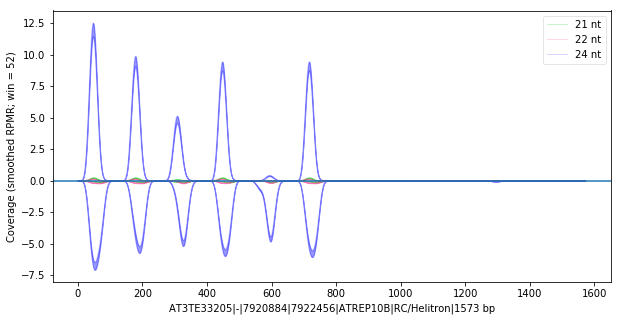

Plotting:

AT5TE60080|+|16641990|16642980|ATREP10D|RC/Helitron|991 bp


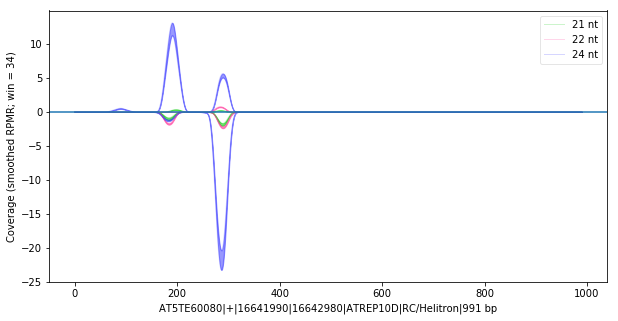

Plotting:

AT4TE60630|-|12956832|12957720|ATREP3|RC/Helitron|889 bp


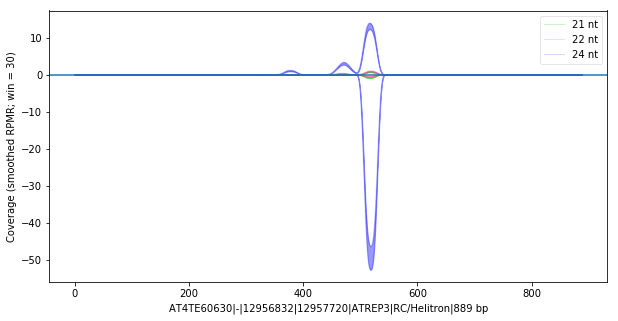

Plotting:

AT3TE41655|+|10008501|10009413|ATREP5|RC/Helitron|913 bp


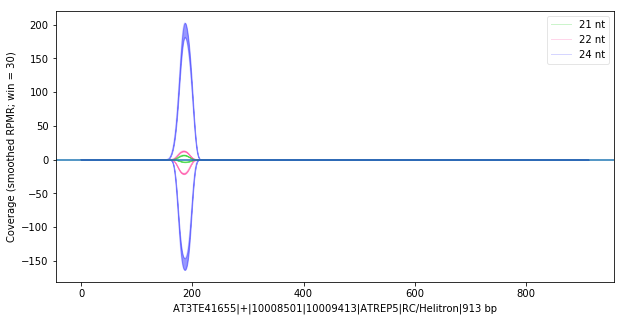

Plotting:

AT2TE22655|+|5607445|5607739|ATREP10A|RC/Helitron|295 bp


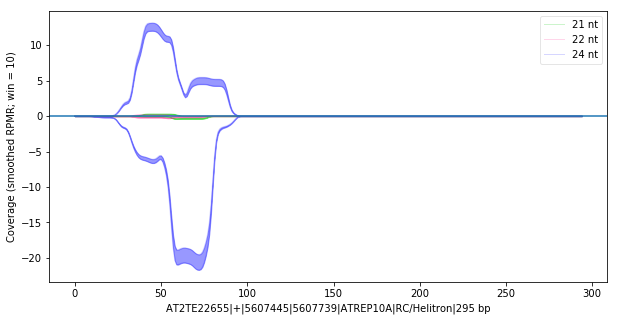

In [43]:
%run /scram_plot/scram_plot.py profile -s helitron \
    -a out_dir/treatment_a_profile -l 21,22,24\
    -cutoff 30

#### Alignment to GFP example

In [44]:
!scram profile -r ref/GFP.fa \
    -1 seq/treatment_a_rep1.fa,seq/treatment_a_rep2.fa,seq/treatment_a_rep3.fa \
    -l 21,22,24 -o out_dir/treatment_a_profile_GFP


Loading reads


SCRAM is attempting to load read files in the default collapsed FASTA format
seq/treatment_a_rep3.fa - 7,897,787 reads processed
seq/treatment_a_rep1.fa - 7,916,958 reads processed
seq/treatment_a_rep2.fa - 7,827,082 reads processed

Loading reference

No. of reference sequences:  1
Combined length of reference sequences: 987 nt

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 24 nt reads

Alignment complete.  Total time taken = 1.719335469s


#### 21, 22 and 24 nt GFP profile plots 
- Note: If only one reference is aligned to, no search term is required for the plot


Loading scram alignment files:

out_dir/treatment_a_profile_GFP_21.csv 

out_dir/treatment_a_profile_GFP_22.csv 

out_dir/treatment_a_profile_GFP_24.csv 

Extracting headers:

Plotting:

GFP


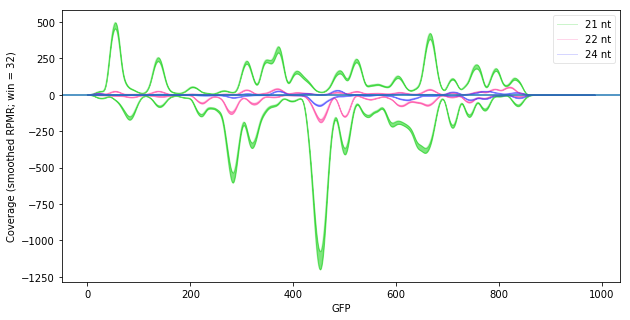

In [45]:
%run /scram_plot/scram_plot.py profile \
    -a out_dir/treatment_a_profile_GFP -l 21,22,24

#### 22 nt GFP profile plot  - with automatic smoothing


Loading scram alignment files:

out_dir/treatment_a_profile_GFP_22.csv 

Extracting headers:

Plotting:

GFP


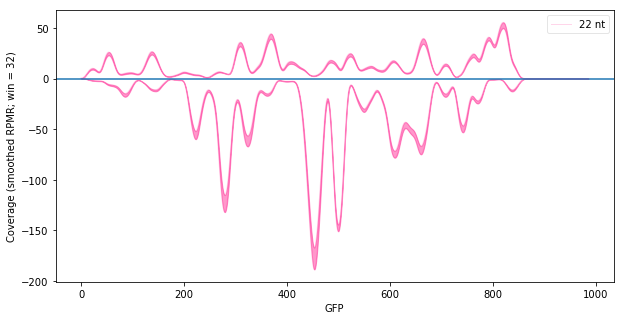

In [46]:
%run /scram_plot/scram_plot.py profile \
    -a out_dir/treatment_a_profile_GFP -l 22

#### 22 nt GFP profile plots  - without smoothing


Loading scram alignment files:

out_dir/treatment_a_profile_GFP_22.csv 

Extracting headers:

Plotting:

GFP


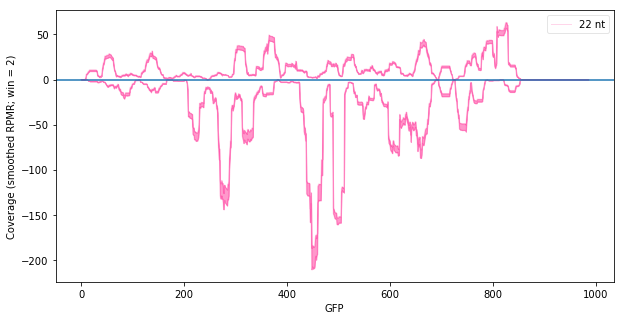

In [47]:
%run /scram_plot/scram_plot.py profile \
    -a out_dir/treatment_a_profile_GFP -l 22 -win 1